In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read the contents of the CSV file into a Pandas DataFrame
df = pd.read_csv('labeled_data.csv',
                      names=['Index','Count','Hate_speech','Offensive_language','Neither','Class','Tweet'], 
                      header=0, index_col=0)

In [3]:
print(df.columns)

Index(['Count', 'Hate_speech', 'Offensive_language', 'Neither', 'Class',
       'Tweet'],
      dtype='object')


In [4]:
# The data is in the following format

# "Count" - number of CrowdFlower users who judged each tweet

# "Hate_speech" - number of CF users who judged the tweet to be hate speech

# "Offensive_language" - number of CF users who judged the tweet to be offensive

# "Neither" - number of CF users who judged the tweet to be neither offensive nor non-offensive

# "Class" - class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

# "Tweet" - text tweet


# As the columns give too much information to the model we will be using just the text for tweets
# and the class of each tweet

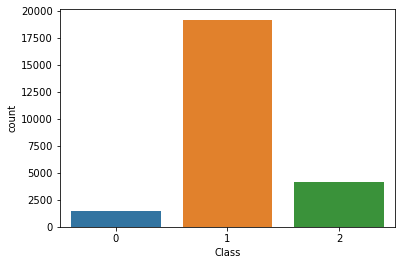

In [5]:
sns.countplot(data=df, x='Class');

In [6]:
# As there are many "offensive" tweets and few "hate" or "neither" tweets, we will make sure to take all of them
# and then take subset of the "offensive" ones

dataset = df[(df.Class == 2) | (df.Class == 0)]

dataset = dataset.append(df[df.Class == 1].head(8000))

number_of_data_examples = dataset.shape[0]

print(number_of_data_examples)

13593


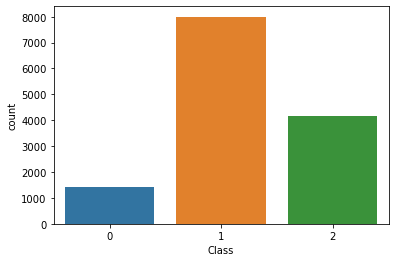

In [7]:
sns.countplot(data=dataset, x='Class');

In [8]:
# Percentage of ["hate", "offensive", "neither"] tweets

print(list((
    sum((dataset.Class == 0).astype(int)) / number_of_data_examples, 
    sum((dataset.Class == 1).astype(int)) / number_of_data_examples,
    sum((dataset.Class == 2).astype(int)) / number_of_data_examples)))

[0.10520120650334731, 0.5885382182005444, 0.3062605752961083]


In [9]:
all_words = dataset['Tweet'].str.split(expand=True).unstack().value_counts()

print(all_words.head(15))

a        4534
the      3756
I        3564
bitch    2829
to       2779
you      2541
and      2089
RT       1857
that     1654
in       1613
is       1518
my       1501
of       1428
like     1260
on       1215
dtype: int64


In [10]:
# As there are many stop words we will remove them

# Convert the text column into a numerical representation using CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
text_column = vectorizer.fit_transform(dataset['Tweet'].tolist())

In [11]:
list(vectorizer.vocabulary_.items())[:10]

[('rt', 19152),
 ('mayasolovely', 14455),
 ('woman', 24581),
 ('shouldn', 20098),
 ('complain', 5499),
 ('cleaning', 5212),
 ('house', 10734),
 ('amp', 2034),
 ('man', 14196),
 ('trash', 22784)]

In [12]:
X = text_column.toarray()
y = dataset['Class'].tolist()

In [13]:
# Split the data into training, validation and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

# Decision Tree Classifier

In [86]:
# We will be using f1 score as our main metric because it is better with inbalanced sets
# such as this one (even thouth we balanced it a bit because it is slow to work with all the data)

In [14]:
def plot_tree_scores(depths):
    train_scores = []
    test_scores = []
    
    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d).fit(X_train, y_train)
        train_score = f1_score(y_train, clf.predict(X_train), average='macro')
        test_score = f1_score(y_val, clf.predict(X_val), average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, color='blue', label='train score')
    plt.plot(depths, test_scores, color='green', label='test score')
    plt.legend()

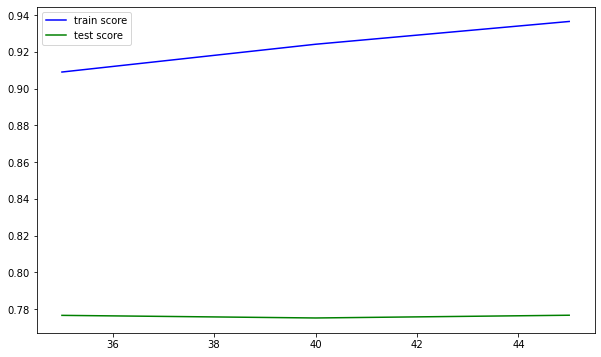

In [15]:
plot_tree_scores(range(35, 50, 5))

In [16]:
# Train a decision tree classifier on the training data

dt_clf = DecisionTreeClassifier(max_depth=35)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=35)

In [17]:
# Evaluate the classifier on the training data

train_score_dt = dt_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_dt)

# Evaluate the classifier on the validation data
val_score_dt = dt_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_dt)

Train Set Accuracy: 0.9393967261357367
Validation Set Accuracy: 0.8712288447387785


In [18]:
print(classification_report(y_val, dt_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.64      0.45      0.53       153
     offense       0.90      0.91      0.91       778
     neither       0.87      0.95      0.91       428

    accuracy                           0.87      1359
   macro avg       0.81      0.77      0.78      1359
weighted avg       0.86      0.87      0.86      1359



In [30]:
res = {'model': ['CVDT35'], 'accuracy': [0.87], 'f1:hate': [0.53], 'weighted_F1': [0.86]}

results = pd.DataFrame(res)

print(results)

    model  accuracy  f1:hate  weighted_F1
0  CVDT35      0.87     0.53         0.86


# Random Forest Classifier

In [24]:
# Train a random forest classifier on the training data

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
# Evaluate the classifier on the training data

train_score_rf = rf_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_rf)

# Evaluate the classifier on the validation data
val_score_rf = rf_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_rf)

Train Set Accuracy: 0.9997241125620747
Validation Set Accuracy: 0.8675496688741722


In [26]:
print(classification_report(y_val, rf_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.67      0.42      0.52       153
     offense       0.88      0.93      0.91       778
     neither       0.89      0.91      0.90       428

    accuracy                           0.87      1359
   macro avg       0.81      0.76      0.77      1359
weighted avg       0.86      0.87      0.86      1359



In [31]:
new_row = pd.Series(['CVRF', 0.87, 0.52, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

print(results)

    model  accuracy  f1:hate  weighted_F1
0  CVDT35      0.87     0.53         0.86
1    CVRF      0.87     0.52         0.86


# Stemming

In [32]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def preprocessor(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(stemmed_tokens)

In [34]:
vectorizer = CountVectorizer(preprocessor=preprocessor)
text_column_new = vectorizer.fit_transform(dataset['Tweet'].tolist())

In [35]:
list(vectorizer.vocabulary_.items())[:10]

[('rt', 16933),
 ('mayasolov', 12872),
 ('woman', 21671),
 ('complain', 4960),
 ('clean', 4720),
 ('hous', 9458),
 ('amp', 1975),
 ('man', 12635),
 ('alway', 1896),
 ('take', 19046)]

In [36]:
X = text_column.toarray()
y = dataset['Class'].tolist()

In [37]:
# Split the data into training, validation and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

# Decision Tree Classifier

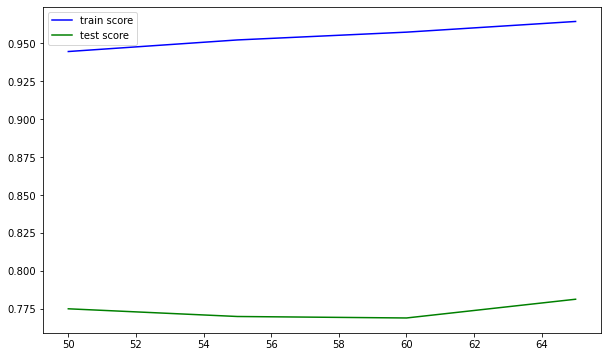

In [38]:
plot_tree_scores(range(50, 70, 5))

In [39]:
# Train a decision tree classifier on the training data

dt_clf = DecisionTreeClassifier(max_depth=50)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50)

In [40]:
# Evaluate the classifier on the training data

train_score_dt = dt_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_dt)

# Evaluate the classifier on the validation data
val_score_dt = dt_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_dt)

Train Set Accuracy: 0.9601802464594446
Validation Set Accuracy: 0.8646063281824872


In [41]:
print(classification_report(y_val, dt_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.61      0.44      0.51       153
     offense       0.90      0.91      0.90       778
     neither       0.86      0.94      0.90       428

    accuracy                           0.86      1359
   macro avg       0.79      0.76      0.77      1359
weighted avg       0.86      0.86      0.86      1359



In [42]:
new_row = pd.Series(['CVSTEMDT', 0.86, 0.51, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# Random Forest Classifier

In [43]:
# Train a random forest classifier on the training data

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
# Evaluate the classifier on the training data

train_score_rf = rf_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_rf)

# Evaluate the classifier on the validation data
val_score_rf = rf_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_rf)

Train Set Accuracy: 0.9996321500827662
Validation Set Accuracy: 0.8668138337012509


In [45]:
print(classification_report(y_val, rf_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.66      0.41      0.51       153
     offense       0.88      0.92      0.90       778
     neither       0.88      0.93      0.90       428

    accuracy                           0.87      1359
   macro avg       0.81      0.75      0.77      1359
weighted avg       0.86      0.87      0.86      1359



In [46]:
new_row = pd.Series(['CVSTEMRF', 0.87, 0.51, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# Naive Bayes Classifier

In [47]:
# Train a naive bayes classifier on the training data

mnb_clf = MultinomialNB()
mnb_clf.fit(X_train, y_train)

MultinomialNB()

In [48]:
# Evaluate the classifier on the training data

train_score_mnb = mnb_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_mnb)

# Evaluate the classifier on the validation data
val_score_mnb = mnb_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_mnb)

Train Set Accuracy: 0.9127276071362884
Validation Set Accuracy: 0.8219278881530537


In [49]:
print(classification_report(y_val, mnb_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.48      0.20      0.29       153
     offense       0.81      0.95      0.88       778
     neither       0.90      0.81      0.85       428

    accuracy                           0.82      1359
   macro avg       0.73      0.65      0.67      1359
weighted avg       0.80      0.82      0.80      1359



In [50]:
new_row = pd.Series(['CVSTEMNB', 0.82, 0.29, 0.80], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

print(results)

      model  accuracy  f1:hate  weighted_F1
0    CVDT35      0.87     0.53         0.86
1      CVRF      0.87     0.52         0.86
2  CVSTEMDT      0.86     0.51         0.86
3  CVSTEMRF      0.87     0.51         0.86
4  CVSTEMNB      0.82     0.29         0.80


# SVM Classifier

In [51]:
def plot_svm_scores(depths):
    train_scores = []
    test_scores = []
    
    for d in depths:
        clf = svm.LinearSVC(C=d, penalty='l2').fit(X_train, y_train)
        train_score = f1_score(y_train, clf.predict(X_train), average='macro')
        test_score = f1_score(y_val, clf.predict(X_val), average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, color='blue', label='train score')
    plt.plot(depths, test_scores, color='green', label='test score')
    plt.legend()

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


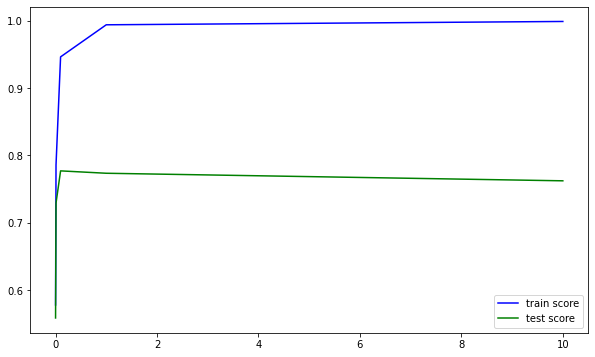

In [52]:
plot_svm_scores(list((0.001, 0.01, 0.1, 1, 10)))

In [53]:
# Train a svm classifier on the training data

svm_clf = svm.LinearSVC(C=0.1)
svm_clf.fit(X_train, y_train)

LinearSVC(C=0.1)

In [54]:
# Evaluate the classifier on the training data

train_score_svm = svm_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_svm)

# Evaluate the classifier on the validation data
val_score_svm = svm_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_svm)

Train Set Accuracy: 0.9691006069523634
Validation Set Accuracy: 0.8668138337012509


In [55]:
print(classification_report(y_val, svm_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.65      0.44      0.53       153
     offense       0.90      0.91      0.90       778
     neither       0.87      0.94      0.90       428

    accuracy                           0.87      1359
   macro avg       0.80      0.76      0.78      1359
weighted avg       0.86      0.87      0.86      1359



In [56]:
new_row = pd.Series(['CVSTEMSVM01', 0.87, 0.53, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# TfidfVectorizer

In [57]:
vectorizer = TfidfVectorizer(preprocessor=preprocessor)
text_column_new = vectorizer.fit_transform(dataset['Tweet'].tolist())

In [58]:
list(vectorizer.vocabulary_.items())[:10]

[('rt', 16933),
 ('mayasolov', 12872),
 ('woman', 21671),
 ('complain', 4960),
 ('clean', 4720),
 ('hous', 9458),
 ('amp', 1975),
 ('man', 12635),
 ('alway', 1896),
 ('take', 19046)]

In [59]:
X = text_column.toarray()
y = dataset['Class'].tolist()

In [60]:
# Split the data into training, validation and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

# Decision Tree Classifier

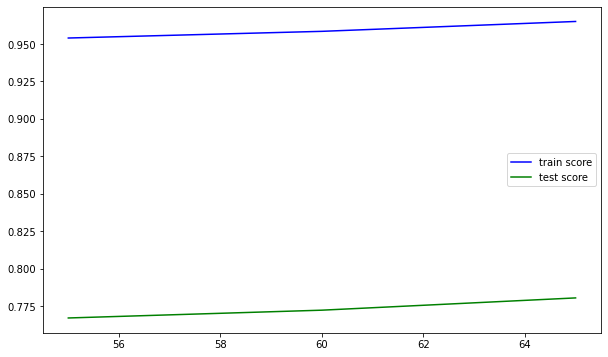

In [61]:
plot_tree_scores(range(55, 70, 5))

In [62]:
# Train a decision tree classifier on the training data

dt_clf = DecisionTreeClassifier(max_depth=65)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=65)

In [63]:
# Evaluate the classifier on the training data

train_score_dt = dt_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_dt)

# Evaluate the classifier on the validation data
val_score_dt = dt_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_dt)

Train Set Accuracy: 0.9732389185212433
Validation Set Accuracy: 0.8631346578366446


In [64]:
print(classification_report(y_val, dt_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.62      0.47      0.54       153
     offense       0.89      0.91      0.90       778
     neither       0.87      0.93      0.90       428

    accuracy                           0.86      1359
   macro avg       0.80      0.77      0.78      1359
weighted avg       0.86      0.86      0.86      1359



In [65]:
new_row = pd.Series(['TDSTEMDT', 0.86, 0.54, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# Random Forest Classifier

In [66]:
def plot_rf_scores(depths):
    train_scores = []
    test_scores = []
    
    for d in depths:
        clf = RandomForestClassifier(n_estimators=d).fit(X_train, y_train)
        train_score = f1_score(y_train, clf.predict(X_train), average='macro')
        test_score = f1_score(y_val, clf.predict(X_val), average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, color='blue', label='train score')
    plt.plot(depths, test_scores, color='green', label='test score')
    plt.legend()

In [68]:
#plot_rf_scores(range(100, 1000, 100))

In [67]:
# Train a random forest classifier on the training data

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [69]:
# Evaluate the classifier on the training data

train_score_rf = rf_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_rf)

# Evaluate the classifier on the validation data
val_score_rf = rf_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_rf)

Train Set Accuracy: 0.9997241125620747
Validation Set Accuracy: 0.869757174392936


In [70]:
print(classification_report(y_val, rf_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.69      0.41      0.52       153
     offense       0.88      0.93      0.91       778
     neither       0.89      0.92      0.90       428

    accuracy                           0.87      1359
   macro avg       0.82      0.75      0.77      1359
weighted avg       0.86      0.87      0.86      1359



In [71]:
new_row = pd.Series(['TDSTEMRF', 0.87, 0.52, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# Naive Bayes Classifier

In [72]:
def plot_mnb_scores(depths):
    train_scores = []
    test_scores = []
    
    for d in depths:
        clf = MultinomialNB(alpha=d).fit(X_train, y_train)
        train_score = f1_score(y_train, clf.predict(X_train), average='macro')
        test_score = f1_score(y_val, clf.predict(X_val), average='macro')
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_scores, color='blue', label='train score')
    plt.plot(depths, test_scores, color='green', label='test score')
    plt.legend()

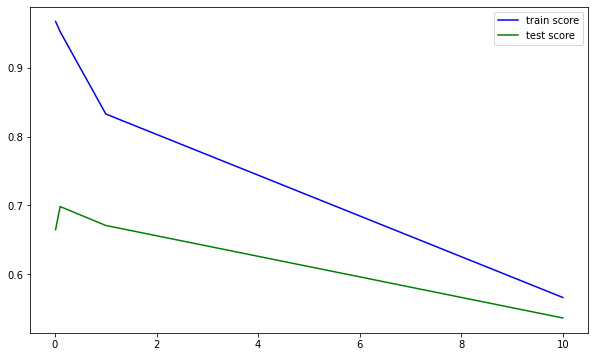

In [73]:
plot_mnb_scores(list((0.01, 0.1, 1, 10)))

In [74]:
# Train a naive bayes classifier on the training data

mnb_clf = MultinomialNB(alpha=0.1)
mnb_clf.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [75]:
# Evaluate the classifier on the training data

train_score_mnb = mnb_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_mnb)

# Evaluate the classifier on the validation data
val_score_mnb = mnb_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_mnb)

Train Set Accuracy: 0.9689166819937466
Validation Set Accuracy: 0.7770419426048565


In [76]:
print(classification_report(y_val, mnb_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.35      0.56      0.43       153
     offense       0.86      0.83      0.85       778
     neither       0.89      0.75      0.82       428

    accuracy                           0.78      1359
   macro avg       0.70      0.72      0.70      1359
weighted avg       0.81      0.78      0.79      1359



In [77]:
new_row = pd.Series(['CVSTEMNB', 0.78, 0.43, 0.79], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# SVM Classifier

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


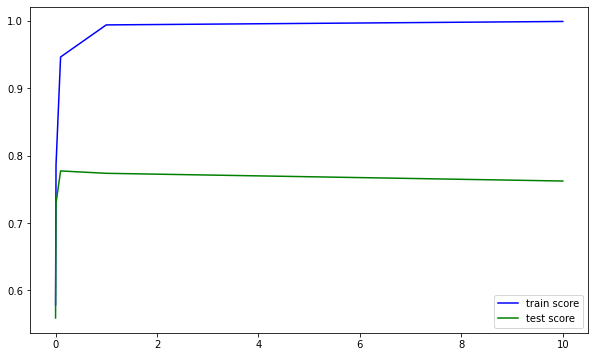

In [78]:
plot_svm_scores(list((0.001, 0.01, 0.1, 1, 10)))

In [79]:
# Train a svm classifier on the training data

svm_clf = svm.LinearSVC(C=0.1)
svm_clf.fit(X_train, y_train)

LinearSVC(C=0.1)

In [80]:
# Evaluate the classifier on the training data

train_score_svm = svm_clf.score(X_train, y_train)
print("Train Set Accuracy:", train_score_svm)

# Evaluate the classifier on the validation data
val_score_svm = svm_clf.score(X_val, y_val)
print("Validation Set Accuracy:", val_score_svm)

Train Set Accuracy: 0.9691006069523634
Validation Set Accuracy: 0.8668138337012509


In [81]:
print(classification_report(y_val, svm_clf.predict(X_val), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.65      0.44      0.53       153
     offense       0.90      0.91      0.90       778
     neither       0.87      0.94      0.90       428

    accuracy                           0.87      1359
   macro avg       0.80      0.76      0.78      1359
weighted avg       0.86      0.87      0.86      1359



In [82]:
new_row = pd.Series(['TDSTEMSVM', 0.87, 0.53, 0.86], index=['model', 'accuracy', 'f1:hate', 'weighted_F1'])
results = results.append(new_row, ignore_index=True)

# Trying the model on the test set

In [83]:
print(results)

         model  accuracy  f1:hate  weighted_F1
0       CVDT35      0.87     0.53         0.86
1         CVRF      0.87     0.52         0.86
2     CVSTEMDT      0.86     0.51         0.86
3     CVSTEMRF      0.87     0.51         0.86
4     CVSTEMNB      0.82     0.29         0.80
5  CVSTEMSVM01      0.87     0.53         0.86
6     TDSTEMDT      0.86     0.54         0.86
7     TDSTEMRF      0.87     0.52         0.86
8     CVSTEMNB      0.78     0.43         0.79
9    TDSTEMSVM      0.87     0.53         0.86


In [84]:
# As this is supposed to be hate speech classifier we would prefer the model with the best 'f1:hate' score. 
# That is the Decision Tree with TfidfVectorizer and Stemming
# As it is on our last version of dataset we can just predict with it


print(classification_report(y_test, dt_clf.predict(X_test), target_names=['hate', 'offense', 'neither']))

              precision    recall  f1-score   support

        hate       0.50      0.41      0.46       135
     offense       0.92      0.89      0.90       809
     neither       0.85      0.94      0.90       416

    accuracy                           0.86      1360
   macro avg       0.76      0.75      0.75      1360
weighted avg       0.86      0.86      0.86      1360



In [85]:
# As a conclusion, it seems that tree-based classifiers do the best job in case of 
# hate speech classification (excluding Neural Networks which would most probably give better results)